# Introduction
* This program that classifies legal issues into a binary value for each National Subject Matter Index (NSMI). (https://nsmi.lsntap.org/browse-v2) \\
"Category" means 20 indexes. \\
"Class" means sub categories under the category.

### Data
* The data contains 2777 labeled articles. Each article has a binary value(0 or 1) that indicates if this article is related to a specific legal class. We ignore unlabeled entries when constructing a model.

### Implementation
* The program converts an article into tf-idf and applies multinomial Naive-Bayes model provided by scikit-learn. 

* After preprocessing data, we predict the model with 10-fold cross-validation.

### Output
* We calculate accuracy with bot categories(20) and classes(100+). \\

See overall result is at the bottom of this notebook.

# Data Preparation (DONE)

In [1]:
!pip3 install PrettyTable
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn

import os
import sys
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None) 
print("DONE")

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


DONE


In [2]:
url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


,_id,full_text,BE-00-00-00-00,BE-01-00-00-00
0,5b60e59cda52255c20cff794,Will he serve time?. Long story short my broth...,0.0,0.0
1,5b60e59cda52255c20cff79a,Groundwater leaking out of street 24/7. Ground...,0.0,0.0
2,5b60e59cda52255c20cff7a0,How do I get my mom's license taken away. My m...,0.0,0.0
3,5b60e59cda52255c20cff7bf,My boss hasn't paid me. What do i do?. I work ...,NaN,NaN
4,5b60e59cda52255c20cff7b8,"[Texas] I signed a non-compete contract, but t...",0.0,0.0
...,...,...,...,...
2772,5b60e66dda52255c20df433f,Do you and your parents get deported because o...,0.0,0.0
2773,5b60e66dda52255c20df43ae,Wondering the legality of a minor (me) being a...,0.0,0.0
2774,5b60e66dda52255c20df4462,Can I sue a billion dollar company in small cl...,0.0,0.0
2775,5b60e66dda52255c20df4448,Sued by creditor and currently in settlement n...,0.0,0.0


## Null and Rowsum Check

In [3]:

#Null Check
#df.isnull().sum()

# Class Check - Remove every column that has zero sum. 
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)


#df.info()


# Remove columns that have <10 positive classes

In [4]:
oldCols = list(df.columns)
print(len(oldCols))

newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)
        
print(len(newCols))

cols = oldCols[:2] + newCols

print(cols)
print(len(cols))

df = df[cols]

df.sum(axis=0, skipna=True)

88
36
['_id', 'full_text', 'BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']
38


_id               5b60e59cda52255c20cff7945b60e59cda52255c20cff7...
full_text         Will he serve time?. Long story short my broth...
BE-00-00-00-00                                                   27
BU-00-00-00-00                                                   93
CO-00-00-00-00                                                  106
CR-00-00-00-00                                                  302
CR-01-00-00-00                                                   12
CR-04-00-00-00                                                   13
CR-06-00-00-00                                                   11
CR-10-00-00-00                                                   11
ED-00-00-00-00                                                   24
ES-00-00-00-00                                                   78
ES-01-00-00-00                                                   10
ES-03-00-00-00                                                   13
FA-00-00-00-00                                  

# Tiny Example: Crime and Prison(CR-00-00-00-00)


## Preprocessing (DONE)

In [5]:
from collections import defaultdict
verbose = True
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))



## Data Preparation

In [6]:

cls = 'CR-00-00-00-00'
dfset = defaultdict() 
preprocessing(dfset, cls)    

#    model[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
tinydf = dfset[cls]
X = tinydf['full_text'].values
Y = tinydf[cls].values


------------Before dropping nan----------------------------------------
                                              full_text  CR-00-00-00-00
0     Will he serve time?. Long story short my broth...             1.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1377
NaN    1098
1.0     302
Nam

## TF-IDF using stopwords, ngram, and C value (TODO)

In [7]:
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
p = len(X) // 10 * 9
tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=300 )
tfidf_vect.fit(X[0:p])
X_train_tfidf_vect = tfidf_vect.transform(X[0:p])
X_test_tfidf_vect = tfidf_vect.transform(X[p:])
lr_clf = LogisticRegression(solver='lbfgs', class_weight='balanced')
lr_clf.fit(X_train_tfidf_vect, Y[0:p])
preds = lr_clf.predict(X_test_tfidf_vect)
precision, recall, fscore, support = score(Y[p:], preds, average='binary')
print('accuracy : {0:.4f}'.format(accuracy_score(Y[p:], preds)))
print('precision: {0:.4f}'.format(precision))
print('recall   : {0:.4f}'.format(recall))
print('fscore   : {0:.4f}'.format(fscore))


from sklearn.model_selection import GridSearchCV

params = {'C':[0.01, 0.1, 1, 5, 10]}
grid_cv_lr = GridSearchCV(lr_clf,param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv_lr.fit(X_train_tfidf_vect, Y[:p])
print(grid_cv_lr.best_params_)

accuracy : 0.9659
precision: 0.9048
recall   : 0.8261
fscore   : 0.8636
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'C': 0.01}


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.0s finished


## Train & Predict (9:1 ratio) (DONE)

In [8]:
from sklearn.pipeline import Pipeline

model_dict = defaultdict()
model_dict[cls] = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=300)),
    ('lr_clf', LogisticRegression(solver='lbfgs',class_weight='balanced', C=0.01))
])
p = len(X) // 10 * 9

model_dict[cls].fit(X[0:p], Y[0:p])
preds = model_dict[cls].predict(X[p:])
print(preds)
accuracy = accuracy_score(Y[p:], preds)
precision, recall, fscore, support = score(Y[p:], preds)
print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]
accuracy: 0.9659090909090909
precision: [0.97419355 0.9047619 ]
recall: [0.9869281  0.82608696]
fscore: [0.98051948 0.86363636]
support: [153  23]


## Download GloVe

In [9]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip

## Unzip

In [12]:
#!unzip glove.6B.zip

In [14]:
from sklearn.pipeline import Pipeline

import numpy as np

#with open("glove.6B.50d.txt", "rb") as lines:
#    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
#           for line in lines}
w2v = {}
with open("glove.6B.50d.txt", "rb") as lines:
    for line in lines:
        val = []
        key = line.split()[0]
        raw = line.split()[1:]
        for x in raw:
            val.append(float(x))
        w2v[key] = val


'''    
i = 0
for k,v in w2v.items():
    if i == 100:
        break
    print(k,v)
    i += 1
'''
#sys.exit()
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 50


    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    


model_dict = defaultdict()
model_dict[cls] = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ('lr_clf', LogisticRegression(solver='lbfgs',class_weight='balanced'))
    
])



p = len(X) // 10 * 9
model_dict[cls].fit(X[0:p], Y[0:p])
preds = model_dict[cls].predict(X[p:])
print(preds)
accuracy = accuracy_score(Y[p:], preds)
precision, recall, fscore, support = score(Y[p:], preds)
print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
accuracy: 0.8693181818181818
precision: [0.86931818 0.        ]
recall: [1. 0.]
fscore: [0.93009119 0.        ]
support: [153  23]


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Calculating Accuracy of One class with 10-fold validation

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression

verbose = True
    
numdoc = defaultdict()
def predict_by_class_force(dfset: defaultdict,cls: str) -> float:
    global model_dict
    preprocessing(dfset, cls)
    #    model_dict[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    

    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    # 10-fold separation with train and test 
    #kfold = KFold(n_splits=10)
    skfold = StratifiedKFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    for train_index, test_index in skfold.split(X, Y):
#        print('#',n_iter)
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index]
        model_dict[cls] = Pipeline([
        ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=300)),
        ('lr_clf', LogisticRegression(solver='lbfgs', class_weight='balanced', C=0.01))
        ])
#        model_dict[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
        model_dict[cls].fit(X_train, Y_train)
        preds = model_dict[cls].predict(X_test)
        n_iter += 1
        #recall = recall_score(Y_test, preds, average='binary')
        accuracy = accuracy_score(Y_test, preds)
        #precision, recall, fscore, support = score(Y_test, preds, average='binary')
        precision, recall, fscore, support = score(Y_test, preds)

        # accuracy: (tp + tn) / (p + n)
        # precision tp / (tp + fp)
        # recall: tp / (tp + fn)
        # f1: 2 tp / (2 tp + fp + fn)

        train_size = X_train.shape[0]
        test_size = X_test.shape[0]
        acc_list.append(accuracy)
        pre_list.append(precision)
        rec_list.append(recall)
        fsc_list.append(fscore)
        sup_list.append(support)

    acc_mean = np.round(np.mean(acc_list), 4)
    pre_mean = np.round(np.mean([x[1] for x in pre_list]), 4)
    rec_mean = np.round(np.mean([x[1] for x in rec_list]), 4)
    fsc_mean = np.round(np.mean([x[1] for x in fsc_list]), 4)
    sup_mean = np.round(np.mean([x[1] for x in sup_list]), 4)
    return (acc_mean, pre_mean, rec_mean, fsc_mean, sup_mean)

#cls = 'BE-00-00-00-00'
cls = 'CR-00-00-00-00'
predict_by_class_force(dfset, cls)

------------Before dropping nan----------------------------------------
                                              full_text  CR-00-00-00-00
0     Will he serve time?. Long story short my broth...             1.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1377
NaN    1098
1.0     302
Nam

(0.9339, 0.8438, 0.7842, 0.8088, 30.2)

## Without Stratified K Fold

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression

verbose = False
    
numdoc = defaultdict()
def predict_by_class(dfset: defaultdict,cls: str) -> float:
    global model_dict
    preprocessing(dfset, cls)
    #    model_dict[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    

    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    # 10-fold separation with train and test 
    #kfold = KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)

    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        model_dict[cls] = Pipeline([
        ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=300)),
        ('lr_clf', LogisticRegression(solver='lbfgs', class_weight='balanced', C=0.01))
        ])
        model_dict[cls].fit(X_train, Y_train)
        out = model_dict[cls].predict(X_test)

        #print(len(out))
        i = 0
        for x in test_index:
            preds[x] = out[i]
            i += 1
            
        #print(preds)

        n_iter += 1
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall: tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)
    
    
    return (accuracy, precision[1], recall[1], fscore[1], support[1])



#cls = 'BE-00-00-00-00'
cls = 'CR-00-00-00-00'
predict_by_class(dfset, cls)

------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679


(0.9357, 0.844, 0.7881, 0.8151, 302)

# Entire Data 

## Build Models and Calculating Accuracies

In [17]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

class_list = df.columns[2:]
print(class_list)
verbose = False
stat_dict = defaultdict() 
for cls in class_list:
    preprocessing(dfset, cls)
    ret = predict_by_class(dfset, cls)
    stat_dict[cls] = ret 
    print('statistics' , ret)

Index(['BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00',
       'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00',
       'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00',
       'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00',
       'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00',
       'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00',
       'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00',
       'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00',
       'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00'],
      dtype='object')
------------------------------------

0.0    1821
1.0      27
Name: BE-00-00-00-00, dtype: int64
data set size 1848
statistics (0.9859, 1.0, 0.037, 0.0714, 27)
------------------------------------

0.0    1497
1.0      93
Name: BU-00-00-00-00, dtype: int64
data set 

## Distribution

In [18]:
!python3 -m pip install prettytable
from prettytable import PrettyTable
t = PrettyTable(["class", "accuracy", "precision", "recall", "F1 score", "support", "|documents|"])
#t.align["class"] = "r"
t.align["accuracy"] = "r"
t.align["precision"] = "r"
t.align["recall"] = "r"
t.align["F1 score"] = "r"
t.align["support"] = "r"
for k,v in stat_dict.items():
    t.add_row([k, v[0], v[1], v[2], v[3], v[4], numdoc[k]])
    
print(t)

+----------------+----------+-----------+--------+----------+---------+-------------+
|     class      | accuracy | precision | recall | F1 score | support | |documents| |
+----------------+----------+-----------+--------+----------+---------+-------------+
| BE-00-00-00-00 |   0.9859 |       1.0 |  0.037 |   0.0714 |      27 |     1848    |
| BU-00-00-00-00 |   0.9692 |      0.94 | 0.5054 |   0.6573 |      93 |     1590    |
| CO-00-00-00-00 |   0.9493 |    0.8133 | 0.5755 |    0.674 |     106 |     1164    |
| CR-00-00-00-00 |   0.9357 |     0.844 | 0.7881 |   0.8151 |     302 |     1679    |
| CR-01-00-00-00 |   0.9914 |       0.0 |    0.0 |      0.0 |      12 |     1393    |
| CR-04-00-00-00 |   0.9907 |       0.0 |    0.0 |      0.0 |      13 |     1402    |
| CR-06-00-00-00 |   0.9922 |       0.0 |    0.0 |      0.0 |      11 |     1404    |
| CR-10-00-00-00 |   0.9944 |       0.0 |    0.0 |      0.0 |      11 |     1969    |
| ED-00-00-00-00 |   0.9884 |       0.8 | 0.1667 |   0

## Plotting for Top10 classes

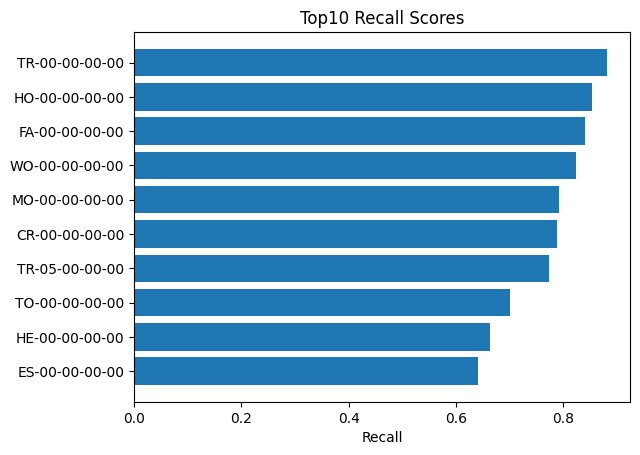

In [19]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()
import collections
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1], reverse=True)
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])

ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Top10 Recall Scores')

plt.show()

## Bottom 20

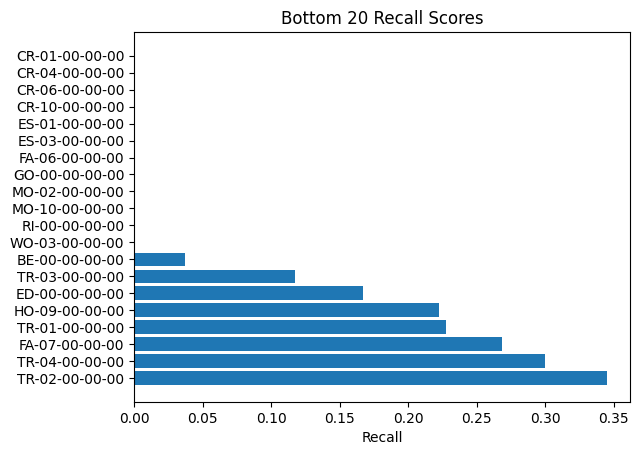

In [20]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()
import collections
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(20)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]
    
sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1])
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])




ax.barh(y_pos[:20], valList[:20], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:20])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Bottom 20 Recall Scores')

plt.show()

## Recall Distribution

    Recall
0     3.70
1    50.54
2    57.55
3    78.81
4     0.00
5     0.00
6     0.00
7     0.00
8    16.67
9    64.10
10    0.00
11    0.00
12   84.03
13   50.00
14    0.00
15   26.83
16    0.00
17   66.39
18   85.45
19   41.18
20   22.22
21   36.11
22   79.23
23    0.00
24   38.46
25    0.00
26    0.00
27   70.00
28   88.08
29   22.73
30   34.48
31   11.76
32   30.00
33   77.42
34   82.43
35    0.00


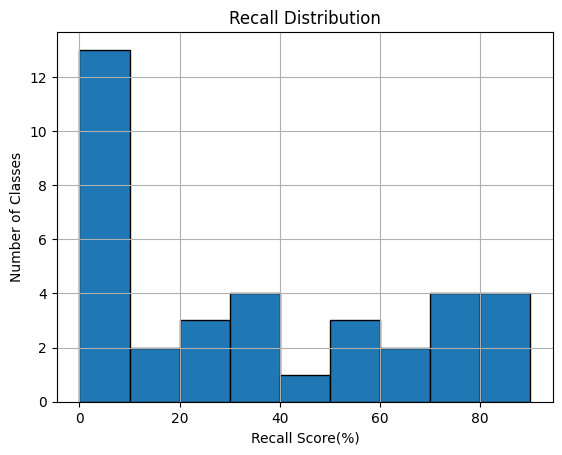

In [21]:
import pylab as pl

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]


recall_list = []
for k,v in recall_dict.items():
    recall_list.append(v*100)
   
d = {'Recall': recall_list}
tinydf = pd.DataFrame(data=d)



hist = tinydf.hist(edgecolor='black', bins = [0,10,20,30,40,50,60,70,80,90])
pl.title("Recall Distribution")
pl.xlabel("Recall Score(%)")
pl.ylabel("Number of Classes")
print(tinydf)

# Custom Input Prediction

In [38]:
input = "How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY state, not very helpful. Can i contact her insurance? Do I contact the police? Has this happened to anyone"

print(input)
predictions = defaultdict() 

prob = defaultdict()
for cls in class_list:
    predictions[cls] = model_dict[cls].predict([input])
    prob[cls] = model_dict[cls].predict_proba([input])
for k,v in predictions.items():
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k][0][1], 4))


How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY stat